## Import libraries and tools

In [86]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## No hybridization model 

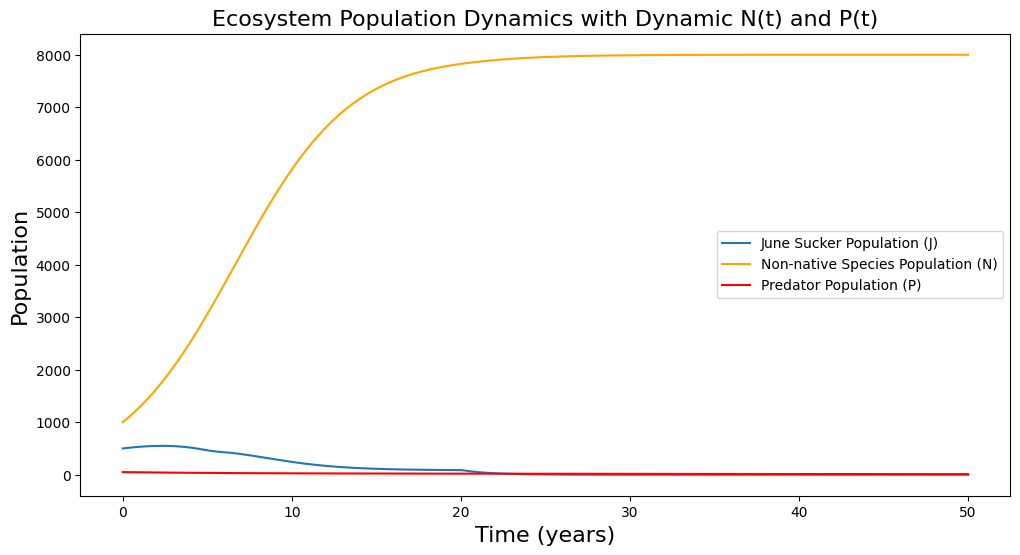

In [87]:
# Define the model parameters
r_J = 0.2            # Intrinsic growth rate of June sucker
K_0 = 5000           # Baseline carrying capacity
alpha = 1e-4         # Competition coefficient
beta = 5e-5          # Predation coefficient
gamma = 0.5          # Effectiveness of human intervention
N = 1000             # Non-native species population
P = 50               # Predator population

# Non-native species parameters
r_N = 0.3            # Intrinsic growth rate of non-native species
K_N = 8000           # Carrying capacity for non-native species
delta = 1e-5         # Competition coefficient (impact of J on N)

# Predator parameters
s = 1e-5             # Predation success rate
m = 0.1              # Mortality rate of predators

# Set the time span for the simulation
t_span = (0, 50)   # Simulate from year 0 to year 50
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Evaluation times

def H(t):
    # Scenario: Constant stocking and habitat restoration between year 5 and 20
    if 5 <= t <= 20:
        return 50    # Stocking rate of 50 fish per year
    else:
        return 0

# Define the carrying capacity function K(t)
def K(t):
    return K_0 + gamma * H(t)

# Redefine the ODE system including N(t) and P(t)
def ecosystem_model(t, y):
    J, N, P = y  # Unpack the variables
    # June sucker population dynamics
    dJdt = r_J * J * (1 - J / K(t)) - alpha * J * N - beta * J * P + H(t)
    # Non-native species population dynamics
    dNdt = r_N * N * (1 - N / K_N) - delta * N * J
    # Predator population dynamics
    dPdt = s * (J + N) * P - m * P
    return [dJdt, dNdt, dPdt]

# Set the initial conditions
J_0 = 500  # Initial June sucker population

# Set initial conditions for N and P
N_0 = 1000  # Initial non-native species population
P_0 = 50    # Initial predator population

# Solve the ODE system
sol = solve_ivp(
    ecosystem_model, t_span, [J_0, N_0, P_0], t_eval=t_eval, method='RK45'
)

# Extract solutions
J_t = sol.y[0]
N_t = sol.y[1]
P_t = sol.y[2]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sol.t, J_t, label='June Sucker Population (J)')
plt.plot(sol.t, N_t, color='orange', label='Non-native Species Population (N)')
plt.plot(sol.t, P_t, color='red', label='Predator Population (P)')
plt.title('Ecosystem Population Dynamics with Dynamic N(t) and P(t)', fontsize=16)
plt.xlabel('Time (years)', fontsize=16)
plt.ylabel('Population', fontsize=16)
plt.legend()
plt.show()


In [94]:
# Define the equilibrium equations
def equilibrium_system(vars):
    J, N, P = vars  # Unpack the variables
    # June sucker population dynamics
    dJdt = r_J * J * (1 - J / K(0)) - alpha * J * N - beta * J * P + H(0)
    # Non-native species population dynamics
    dNdt = r_N * N * (1 - N / K_N) - delta * N * J
    # Predator population dynamics
    dPdt = s * (J + N) * P - m * P
    return [dJdt, dNdt, dPdt]

# Initial guess for the solver
initial_guess = [500, 1000, 50]  # Initial populations of J, N, P

# Solve the system
equilibrium_points = fsolve(equilibrium_system, initial_guess)

# Extract and print the equilibrium points
J_eq, N_eq, P_eq = equilibrium_points
print(f"Equilibrium Population of June Suckers (J): {J_eq:.2f}")
print(f"Equilibrium Population of Non-native Species (N): {N_eq:.2f}")
print(f"Equilibrium Population of Predators (P): {P_eq:.2f}")


Equilibrium Population of June Suckers (J): 0.00
Equilibrium Population of Non-native Species (N): 0.00
Equilibrium Population of Predators (P): 0.00


## Final combined model

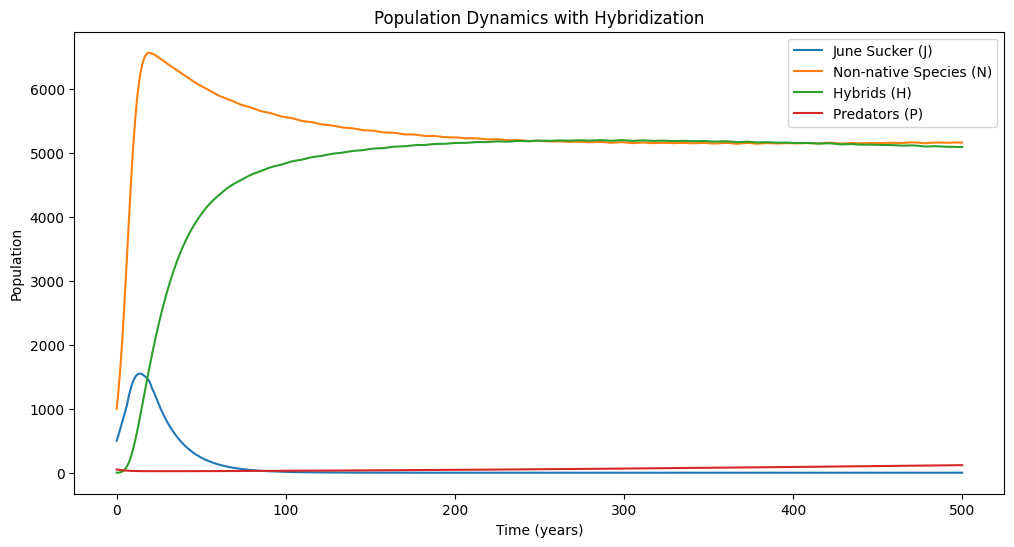

In [89]:
# Updated model parameters including hybrids
r_J = 0.2
r_N = 0.3
r_H = 0.25
K_0 = 10000
c_JN = c_NJ = 1.0
c_JH = c_NH = c_HJ = c_HN = 0.9
beta_J = beta_N = beta_H = 5e-5
s_H = 1e-5
s_P = 1e-5
m_P = 0.1
gamma = 0.5

# Human intervention functions (updated)
def H_J(t):
    return 50 if 5 <= t <= 20 else 0

def H_N(t):
    return -10

def H_H(t):
    return -5

# Carrying capacity function (updated)
def K(t):
    return K_0 + gamma * H_J(t)

# ODE system including hybrids
def ecosystem_model_hybrid(t, y):
    J, N, H, P = y
    dJdt = (
        r_J * J * (1 - (J + c_JN * N + c_JH * H) / K(t))
        - beta_J * J * P
        - s_H * J * N
        + H_J(t)
    )
    dNdt = (
        r_N * N * (1 - (N + c_NJ * J + c_NH * H) / K(t))
        - beta_N * N * P
        - s_H * J * N
        + H_N(t)
    )
    dHdt = (
        s_H * J * N
        + r_H * H * (1 - (H + c_HJ * J + c_HN * N) / K(t))
        - beta_H * H * P
        + H_H(t)
    )
    dPdt = s_P * (J + N + H) * P - m_P * P
    return [dJdt, dNdt, dHdt, dPdt]

# Time span and initial conditions
t_span = (0, 500) # Adjusted time span to determine when equilibrium takes place
t_eval = np.linspace(*t_span, 500)
initial_conditions = [500, 1000, 0, 50]  # J_0, N_0, H_0, P_0

# Solving the ODE system
solution = solve_ivp(ecosystem_model_hybrid, t_span, initial_conditions, t_eval=t_eval)

# Extracting results
J_t, N_t, H_t, P_t = solution.y

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(solution.t, J_t, label='June Sucker (J)')
plt.plot(solution.t, N_t, label='Non-native Species (N)')
plt.plot(solution.t, H_t, label='Hybrids (H)')
plt.plot(solution.t, P_t, label='Predators (P)')
plt.title('Population Dynamics with Hybridization')
plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.legend()
plt.show()

## Calculate equilibrium points of final combined model

In [90]:
# Redefine the system with no time dependence for equilibrium analysis
def equilibrium_system(y, t=0):
    J, N, H, P = y
    dJdt = (
        r_J * J * (1 - (J + c_JN * N + c_JH * H) / K_0)
        - beta_J * J * P
        - s_H * J * N
        + 50 # Assuming constant stocking of June suckers
    )
    dNdt = (
        r_N * N * (1 - (N + c_NJ * J + c_NH * H) / K_0)
        - beta_N * N * P
        - s_H * J * N
        - 10  # Assuming constant removal of non-native species
    )
    dHdt = (
        s_H * J * N
        + r_H * H * (1 - (H + c_HJ * J + c_HN * N) / K_0)
        - beta_H * H * P
        - 5  # Assuming constant removal of hybrids
    )
    dPdt = s_P * (J + N + H) * P - m_P * P
    return [dJdt, dNdt, dHdt, dPdt]

# Solve for equilibrium
J_eq, N_eq, H_eq, P_eq = fsolve(equilibrium_system, initial_conditions)

# Print the results
print(f"Equilibrium June Sucker Population (J):        {J_eq}")
print(f"Equilibrium Non-native Species Population (N): {N_eq}")
print(f"Equilibrium Hybrid Population (H):             {H_eq}")
print(f"Equilibrium Predator Population (P):           {P_eq}")

Equilibrium June Sucker Population (J):        -245.60430962500055
Equilibrium Non-native Species Population (N): 32.43469781599387
Equilibrium Hybrid Population (H):             19.97531368896398
Equilibrium Predator Population (P):           3.3645717464827046e-09


## Calculate when equilibrium points occur

In [91]:
# Equilibrium points
equilibrium_values = [-245.60, 32.43, 19.98, 0]  # Suppose June Sucker equilibrium is 0 instead of -245.60
tolerance = 1e-2  # Define a tolerance for "close to equilibrium"

# Time points and species populations from the solution
time_points = solution.t
populations = solution.y  # J_t, N_t, H_t, P_t

# Find the time when each species hits equilibrium
def find_equilibrium_time(time_points, population, equilibrium_value, tolerance):
    for t, pop in zip(time_points, population):
        if abs(pop - equilibrium_value) <= tolerance:
            return t
    return None  # Return None if equilibrium is not reached

equilibrium_times = [
    find_equilibrium_time(time_points, species_pop, eq_value, tolerance)
    for species_pop, eq_value in zip(populations, equilibrium_values)
]

# Display results
species_names = ["June Sucker (J)", "Non-native Species (N)", "Hybrid (H)", "Predator (P)"]
for species, eq_time in zip(species_names, equilibrium_times):
    if eq_time is not None:
        print(f"{species} reaches equilibrium at t = {eq_time:.2f}")
    else:
        print(f"{species} does not reach equilibrium within the simulation time.")


June Sucker (J) does not reach equilibrium within the simulation time.
Non-native Species (N) does not reach equilibrium within the simulation time.
Hybrid (H) does not reach equilibrium within the simulation time.
Predator (P) does not reach equilibrium within the simulation time.


## Create phase plots

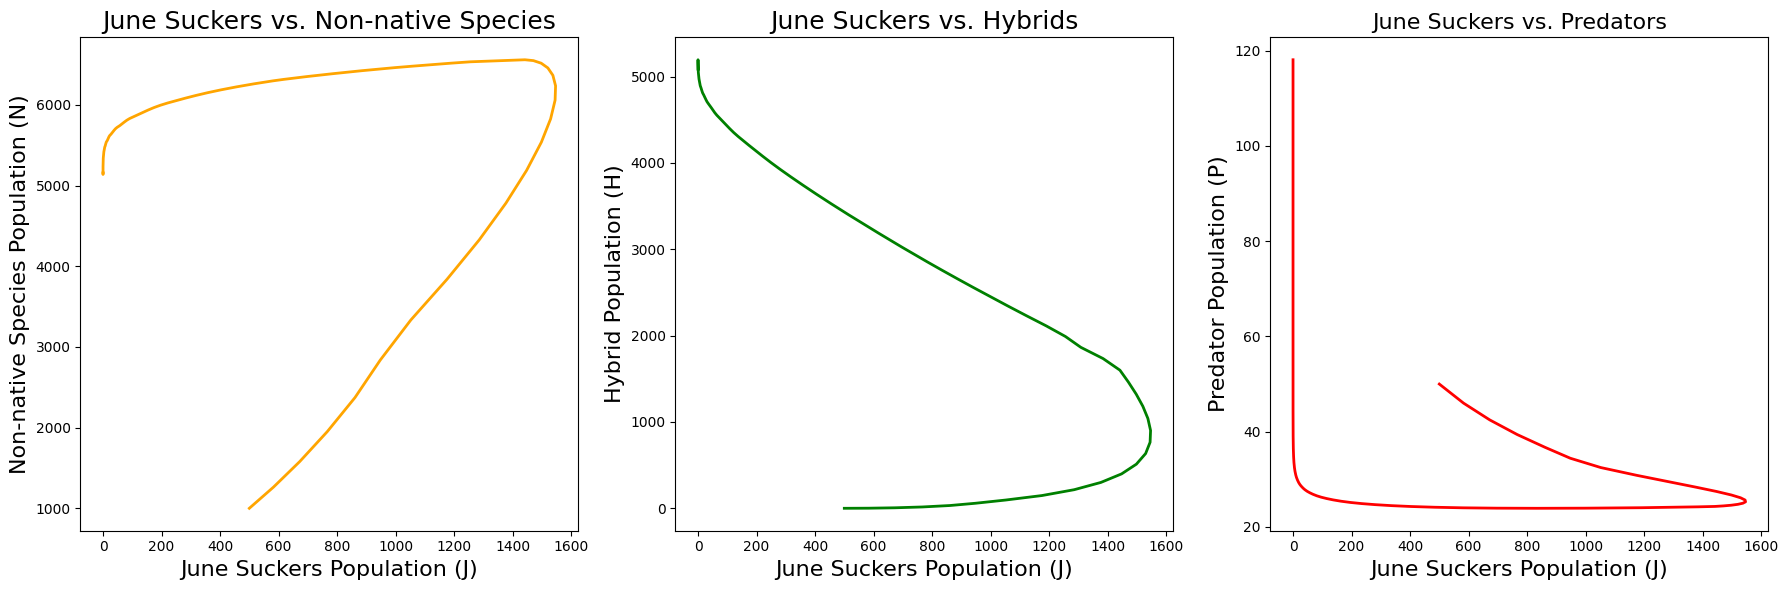

In [92]:
# Create a figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Phase plot 1: June suckers vs. non-native species
axes[0].plot(J_t, N_t, lw=2, color='orange')
axes[0].set_title('June Suckers vs. Non-native Species', fontsize=18)
axes[0].set_xlabel('June Suckers Population (J)', fontsize=16)
axes[0].set_ylabel('Non-native Species Population (N)', fontsize=16)

# Phase plot 2: June suckers vs. hybrids
axes[1].plot(J_t, H_t, lw=2, color='green')
axes[1].set_title('June Suckers vs. Hybrids', fontsize=18)
axes[1].set_xlabel('June Suckers Population (J)', fontsize=16)
axes[1].set_ylabel('Hybrid Population (H)', fontsize=16)

# Phase plot 3: June suckers vs. predators
axes[2].plot(J_t, P_t, lw=2, color='red')
axes[2].set_title('June Suckers vs. Predators', fontsize=16)
axes[2].set_xlabel('June Suckers Population (J)', fontsize=16)
axes[2].set_ylabel('Predator Population (P)', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
